#[Problem 1] Confirmation of competition contents


**What to learn and what to predict?** \\
We build a model that input users multiple informations and try to predict whether client is capable for on-time repayment

**What kind of file to create and submit to Kaggle?** \\
A csv file containing 2 columns: SK_ID_CURR which identifies each data point in the test set, and TARGET as prediction outcome

**What kind of index value will be used to evaluate the submissions?** \\
Area under the ROC curve. An ROC curve is evaluate and drawn based on setting different threshold for each outcome. Evaluate area under the curve can tell us how effective our model is compare to other model, or baseline.



#[Problem 2] Learning and verification
Create and execute a series of steps from easy analysis, preprocessing, learning, and verification of data.


For verification, please use the evaluation metrics used in this competition. The method used for learning is not specified.

Wow this is alot.

In [23]:
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.impute import SimpleImputer

In [24]:
pd_data = pd.read_csv('application_train.csv')
pd_test = pd.read_csv('application_test.csv')

In [25]:
pd_data.head(5)
pd_test.head(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0,1,1,1,1,0,0,NaN,3.0,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-821.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
pd_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108657 entries, 0 to 108656
Data columns (total 122 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   SK_ID_CURR                    int64  
 1   TARGET                        int64  
 2   NAME_CONTRACT_TYPE            object 
 3   CODE_GENDER                   object 
 4   FLAG_OWN_CAR                  object 
 5   FLAG_OWN_REALTY               object 
 6   CNT_CHILDREN                  int64  
 7   AMT_INCOME_TOTAL              float64
 8   AMT_CREDIT                    float64
 9   AMT_ANNUITY                   float64
 10  AMT_GOODS_PRICE               float64
 11  NAME_TYPE_SUITE               object 
 12  NAME_INCOME_TYPE              object 
 13  NAME_EDUCATION_TYPE           object 
 14  NAME_FAMILY_STATUS            object 
 15  NAME_HOUSING_TYPE             object 
 16  REGION_POPULATION_RELATIVE    float64
 17  DAYS_BIRTH                    float64
 18  DAYS_EMPLOYED          

In [27]:
def missing_table(data):
  num = data.isnull().sum()
  pct = num / len(data) * 100
  tab = pd.concat([num, pct], axis=1, keys=['missing value', 'percentage']).sort_values('percentage', ascending=False)
  print(tab)

In [28]:
missing_table(pd_data)

                          missing value  percentage
COMMONAREA_MEDI                   75833   69.791178
COMMONAREA_AVG                    75833   69.791178
COMMONAREA_MODE                   75833   69.791178
NONLIVINGAPARTMENTS_MODE          75324   69.322731
NONLIVINGAPARTMENTS_AVG           75324   69.322731
...                                 ...         ...
CNT_CHILDREN                          0    0.000000
AMT_INCOME_TOTAL                      0    0.000000
NAME_INCOME_TYPE                      0    0.000000
TARGET                                0    0.000000
SK_ID_CURR                            0    0.000000

[122 rows x 2 columns]


In [29]:
missing_table(pd_test)

                          missing value  percentage
COMMONAREA_AVG                    33495   68.716150
COMMONAREA_MODE                   33495   68.716150
COMMONAREA_MEDI                   33495   68.716150
NONLIVINGAPARTMENTS_AVG           33347   68.412523
NONLIVINGAPARTMENTS_MODE          33347   68.412523
...                                 ...         ...
NAME_HOUSING_TYPE                     0    0.000000
NAME_FAMILY_STATUS                    0    0.000000
NAME_EDUCATION_TYPE                   0    0.000000
NAME_INCOME_TYPE                      0    0.000000
SK_ID_CURR                            0    0.000000

[121 rows x 2 columns]


##Inspect Variable
###TARGET
From the bar chart below, we can easily deduce that this is an imbalanced class problem

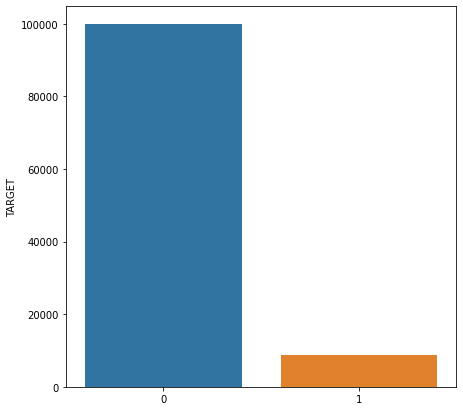

In [30]:
count_target = pd_data['TARGET'].value_counts()
plt.figure(figsize=(7, 7))
sns.barplot(y=count_target, x=count_target.index)

### Other

In [31]:
pd_data.dtypes.value_counts()

float64    103
object      16
int64        3
dtype: int64

We can see that there are 16 categorical variable (object). We need to convert these categorical variable to discrete variable. \\
There are 2 ways we can perform this conversion:
- One-hot encoding: assign each variable with n distinct category n flags.
- Label encoding: each category is assigned a numerical value. (use for small category variable)

In [32]:
catvar = pd_data.select_dtypes('object').apply(pd.Series.nunique, axis=0)
catvar

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               9
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

**Label Encoding**

In [33]:
from sklearn.preprocessing import LabelEncoder

# get index of category variable with 2 cat
catvar = catvar[catvar == 2].index
le = LabelEncoder()
for i in catvar:
  le.fit(pd_data[i].astype(str))
  pd_data[i] = le.transform(pd_data[i].astype(str))
  pd_test[i] = le.transform(pd_test[i].astype(str))

**One-hot Encoding and Aligning**

In [34]:
pd_data = pd.get_dummies(pd_data)
pd_test = pd.get_dummies(pd_test)

pd_data.dtypes.value_counts()

target = pd_data['TARGET']

pd_data, pd_test = pd_data.align(pd_test, join='inner', axis=1)
pd_data['TARGET'] = target

Variable DAY_BIRTH accounts for number of days since birth ( naturally negative ).

In [35]:
pd_data['DAYS_BIRTH'] = abs(pd_data['DAYS_BIRTH'])

## Correlation

In [36]:
target_corr = pd_data.corr()['TARGET'].sort_values(ascending=False)

print("Top 10 positive correlation feature:")
print(target_corr.head(10), '\n\n')
print("Top 10 negative correlation feature:")
print(target_corr.tail(10))

Top 10 positive correlation feature:
TARGET                                               1.000000
REGION_RATING_CLIENT_W_CITY                          0.062118
REGION_RATING_CLIENT                                 0.060756
NAME_INCOME_TYPE_Working                             0.058198
CODE_GENDER_M                                        0.054988
DAYS_LAST_PHONE_CHANGE                               0.052319
DAYS_ID_PUBLISH                                      0.051958
NAME_EDUCATION_TYPE_Secondary / secondary special    0.050506
REG_CITY_NOT_WORK_CITY                               0.049408
EMERGENCYSTATE_MODE                                  0.045800
Name: TARGET, dtype: float64 


Top 10 negative correlation feature:
HOUSETYPE_MODE_block of flats          -0.044892
FLOORSMAX_MODE                         -0.045804
FLOORSMAX_MEDI                         -0.046673
FLOORSMAX_AVG                          -0.047234
CODE_GENDER_F                          -0.054969
NAME_EDUCATION_TYPE_Higher ed

## Pre-processing


In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

train = pd_data.drop('TARGET', axis=1).copy()
features = list(pd_data.columns)
test = pd_test.copy()

## FILL IN MISSING VALUE
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)

## STANDARDIZING VARIABLE
scaler = StandardScaler()

scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: {}'.format(train.shape))
print('Testing data shape: {}'.format(test.shape))

Training data shape: (108657, 238)
Testing data shape: (48744, 238)


#Problem 3: Base-line models

In [38]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


def learn_model(X_train, y_train,X_test, model):
  model.fit(X_train, y_train)

  y_pred = model.predict_proba(X_test)
  return y_pred

In [39]:
lgr = SGDClassifier(loss='log', n_jobs=-1, random_state=50)
y_pred_lgr = learn_model(train, target, test, lgr)

y_pred_lgr

array([[0.91001226, 0.08998774],
       [0.73341857, 0.26658143],
       [0.86166643, 0.13833357],
       ...,
       [0.93864709, 0.06135291],
       [0.91603378, 0.08396622],
       [0.87991539, 0.12008461]])

In [40]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
y_pred_rfc = learn_model(train, target, test, rfc)

y_pred_rfc

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   44.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.4s finished


array([[0.87, 0.13],
       [0.89, 0.11],
       [0.89, 0.11],
       ...,
       [0.86, 0.14],
       [0.74, 0.26],
       [0.79, 0.21]])

# Problem 4: Feature Engineering

Polynomial Features

In [41]:
pd_data = pd.read_csv('application_train.csv')
pd_test = pd.read_csv('application_test.csv')

In [63]:
# new dataframe

poly_features = pd_data[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = pd_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
print(poly_features.dtypes.value_counts())
# imputer for handling missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])
features = list(poly_features.columns)

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)
poly_transformer.get_feature_names(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

float64    3
int64      2
dtype: int64
Polynomial Features shape:  (128091, 35)
float64


['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [72]:
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))
poly_features = pd.DataFrame(poly_features)
print(pd_data.dtypes.value_counts())
# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = pd_data['SK_ID_CURR']
df_train_poly = pd_data.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = pd_test['SK_ID_CURR']
df_test_poly = pd_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
df_train_poly, df_test_poly = df_train_poly.align(df_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', df_train_poly.shape)
print('Testing data with polynomial features shape:  ', df_test_poly.shape)

float64    85
int64      21
object     16
dtype: int64
Training data with polynomial features shape:  (128091, 117)
Testing data with polynomial features shape:   (48744, 117)


In [80]:
train = poly_features.copy()
# features = list(df_train_poly.columns)
test = poly_features_test.copy()
target = poly_target.copy()
# ## FILL IN MISSING VALUE
# imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# imputer.fit(train)
# train = imputer.transform(train)
# test = imputer.transform(test)

# ## STANDARDIZING VARIABLE
# scaler = StandardScaler()

# scaler.fit(train)
# train = scaler.transform(train)
# test = scaler.transform(test)

# print('Training data shape: {}'.format(train.shape))
# print('Testing data shape: {}'.format(test.shape))
target.shape

(128091,)

In [81]:
lgr = SGDClassifier(loss='log', n_jobs=-1, random_state=50)
y_pred_lgr = learn_model(train, target, test, lgr)

y_pred_lgr

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [83]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
y_pred_rfc = learn_model(train, target, test, rfc)

y_pred_rfc

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    1.1s finished


array([[0.87, 0.13],
       [0.88, 0.12],
       [0.97, 0.03],
       ...,
       [0.77, 0.23],
       [0.86, 0.14],
       [0.78, 0.22]])